In [1]:
%pylab inline
import sklearn.cluster
import itertools

Populating the interactive namespace from numpy and matplotlib


In [2]:
orig_data = data = np.load("vessels_gear_embedding.npz")["data"]

In [3]:
width = 19200
labels = ['cargo', 'tanker', 'trawlers', 'sailing', 'set_gillnets', 'pole_and_line', 'motor_passenger', 'reefer', 'tug', 'set_longlines', 'pots_and_traps', 'other_not_fishing', 'gear', 'squid_jigger', 'seismic_vessel', 'purse_seines', 'drifting_longlines', 'other_fishing', 'trollers']
label_to_idx = {label: idx for idx, label in enumerate(labels)}
idx_to_label = {idx: label for idx, label in enumerate(labels)}


In [4]:
datasize = 10000
res = None
for idx in xrange(0, len(labels)):
    chunk = data[data[:,width+4] == idx]
    chunk = chunk[np.random.randint(len(chunk), size=datasize / len(labels)),:]
    if res is None:
        res = chunk
    else:
        res = np.append(res, chunk, axis=0)
data = res

In [5]:
stds = data[:,:width].std(axis=0)
means = data[:,:width].mean(axis=0)
data[:,:width] -= means
data[:,:width] /= (stds+1e-30)

In [6]:
nclusters=25
clustering = sklearn.cluster.AgglomerativeClustering(linkage="ward", n_clusters=nclusters)

In [7]:
clustering.fit(data[:,:width])

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward',
            memory=Memory(cachedir=None), n_clusters=25,
            pooling_func=<function mean at 0x7feea6f47410>)

In [8]:
cm = np.zeros((nclusters, len(labels)))
for i in xrange(0, nclusters):
    cm[i,:] = data[clustering.labels_ == i][:,width+6:width+6+len(labels)].mean(axis=0)

In [9]:
def plot_confusion_matrix(cm, xclasses, yclasses,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          xlabel='Predicted label', ylabel='True label'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    xtick_marks = np.arange(len(xclasses))
    plt.xticks(xtick_marks, xclasses, rotation=90)
    ytick_marks = np.arange(len(yclasses))
    plt.yticks(ytick_marks, yclasses)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.tight_layout()
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

Confusion matrix, without normalization


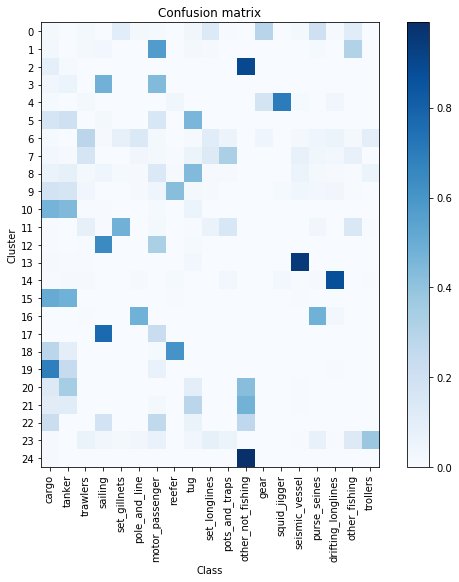

In [10]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, labels, [str(l) for l in xrange(0, nclusters)], ylabel='Cluster', xlabel='Class')

In [11]:
len(labels)

19

In [12]:
np.append

<function numpy.lib.function_base.append>